In [2]:
###### test connection ######

import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"

In [3]:
###### check environments ######

import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])

ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
ocid1.datascienceproject.oc1.eu-zurich-1.amaaaaaa2jwq32iapkcl4klg3qulxmpxlgnyxwhf276mb6ukgtdhms5oc3ua
ocid1.saml2idp.oc1..aaaaaaaao4zb7iwgmzbhs3hcvl7qrob453qzrqzs3o2hhl23oczezxmtyz7q/ethlambda@gmail.com
ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
eu-zurich-1


In [21]:
%%bash
###### install libs ######
#pip install matplotlib
#pip install pandas
#pip install seaborn
#pip list
#pip install scikit-learn

In [4]:
###### import libs ######

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import gzip
import pickle
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

In [5]:
###### check ads env ######

ads.environment.ads_inspect.check_ads_env()

Library         Version    Required
--------------  ---------  ----------
arrow           0.14.7     0.10.0
configparser    4.0.2      3.5.0
ipykernel       5.4.0      5.1.3
pyod            0.8.1      0.7.1
pyOpenSSL       18.0.0     19.0
pytest          4.0.1      5.3.5
pytest-asyncio  0.9.0      0.10.0
six             1.14.0     1.13


In [6]:
####### load data #######

name = 'kdd_clean'
id_col = ""
target_col = "is_exciting_20"

train_name = './{}/train_{}.csv'.format(name, name)
test_name = './{}/test_{}.csv'.format(name, name)

df = pd.read_csv(train_name)
test_df = pd.read_csv(test_name)

print(df.head())
df.shape

test_df.head()

  secondary_focus_subject  primary_focus_subject  school_latitude     cost  \
0             Visual Arts            Mathematics        41.807654  1225.44   
1             Mathematics  Environmental Science        35.431974   232.01   
2                     ESL   Literature & Writing        37.943016   315.31   
3        Applied Sciences  College & Career Prep        25.714563   466.00   
4    Literature & Writing               Literacy        40.793018  2889.99   

   school_longitude  Vol_teacher_acctid resource_type  \
0        -87.673257                  55      Supplies   
1       -119.015723                   6      Supplies   
2       -122.364521                   8      Supplies   
3        -80.304710                  15    Technology   
4        -73.205635                  11    Technology   

  teacher_teach_for_america  Vol_school_city  school_zip  ...  \
0                         f             9260        9590  ...   
1                         f             2363       15270  

,secondary_focus_subject,primary_focus_subject,school_latitude,cost,school_longitude,Vol_teacher_acctid,resource_type,teacher_teach_for_america,Vol_school_city,school_zip,...,donor_state_H1_sum_donation_total,donor_state_H1_mean_gave_2_exciting,donor_state_H1_mean_donation_total,donor_zip_H1_nb_donations,donor_zip_H1_sum_gave_2_exciting,donor_zip_H1_sum_donation_total,donor_zip_H1_mean_gave_2_exciting,donor_zip_H1_mean_donation_total,date_posted,is_exciting_20
0,Special Needs,Literature & Writing,40.461702,138.64,-79.827803,7,Technology,f,310,949,...,186963.59,0.123457,53.678895,6,0,209.00,0.000000,34.833333,2013-08-29,0
1,Performing Arts,Music,32.465762,119.98,-84.888363,22,Other,f,1495,4057,...,243227.20,0.271517,42.037193,10,3,443.00,0.300000,44.300000,2013-12-09,0
2,Mathematics,Applied Sciences,40.819389,198.58,-73.957037,6,Supplies,f,4043,23,...,2602507.44,0.083356,64.353192,22,4,1022.94,0.181818,46.497273,2013-05-24,0
3,Mathematics,Literature & Writing,40.832025,125.33,-73.906682,8,Supplies,f,5329,74,...,2602507.44,0.083356,64.353192,4,0,145.00,0.000000,36.250000,2013-07-13,0
4,Mathematics,Literature & Writing,35.349696,254.24,-119.162331,2,Books,f,2363,15275,...,1569060.25,0.113790,62.537276,38,2,1235.88,0.052632,32.523158,2013-08-01,0


[0 1]


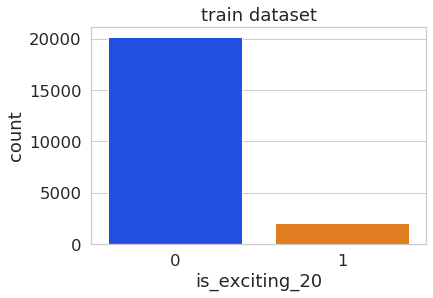

In [7]:
### dataset statistics ######
sns.countplot(x=target_col, data=df)
plt.title("train dataset")
print(df[target_col].unique())

In [9]:
###### train model ######

train = DatasetFactory.open(df).set_target(target_col)
print([train])

# create an automl job
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)
oracle_automl = AutoML(training_data = train, provider=ml_engine)

# time budget is in seconds
best_model, baseline = oracle_automl.train(score_metric='roc_auc', time_budget=1800)

[BinaryClassificationDataset(target: is_exciting_20) 22,196 rows, 101 columns]


Training Dataset size,"(22196, 100)"
Validation Dataset size,None
CV,5
Target variable,is_exciting_20
Optimization Metric,roc_auc
Initial number of Features,100
Selected number of Features,59
Selected Features,"[school_latitude, cost, school_longitude, Vol_teacher_acctid, school_zip, school_city, Vol_schoolid, Vol_school_county, school_district, Vol_school_zip, Vol_school_district, schoolid, eligible_double_your_impact_match, teacher_acctid, essaystring_max, essayNbWords, essayNbSentences, essayWordsMeanInSent, essayQuotM, essayComma, essayPErr, lapse, lapse2, lapse3, lapse_m1, H1_sum_gexciting, H1_sum_g10_to_100, H1_sum_gunder_10, H1_sum_sponsored_distance, title, essay, essay_great_messages_proportion, essay_teacher_referred_count, essay_non_teacher_referred_count, essay_t_1p_num, essay_green_num, essay_great_chat_num, essay_nt_3p_num, Normal_Cost, Cost_Deviation, item_exciting, history_chunck, donor_city_H1_nb_donations, donor_city_H1_sum_gave_2_exciting, donor_city_H1_sum_donation_total, donor_city_H1_mean_gave_2_exciting, donor_city_H1_mean_donation_total, donor_state_H1_nb_donations, donor_state_H1_sum_gave_2_exciting, donor_state_H1_sum_donation_total, donor_state_H1_mean_gave_2_ex..."
Selected Algorithm,RandomForestClassifier
End-to-end Elapsed Time (seconds),1289
Selected Hyperparameters,"{'class_weight': 'balanced', 'max_features': 0.3608791424375324, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.010005269831483454, 'n_estimators': 253}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,RandomForestClassifier_HT,22196,59,0.7163,"{'class_weight': 'balanced', 'max_features': 0.3608791424375324, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.010005269831483454, 'n_estimators': 252}",82.3057
3,RandomForestClassifier_HT,22196,59,0.7163,"{'class_weight': 'balanced_subsample', 'max_features': 0.3608791424375324, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.010005269831483454, 'n_estimators': 253}",90.8073
4,RandomForestClassifier_HT,22196,59,0.7162,"{'class_weight': 'balanced_subsample', 'max_features': 0.3608791424375324, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.010005269831483454, 'n_estimators': 252}",89.8296
5,RandomForestClassifier_HT,22196,59,0.7152,"{'class_weight': 'balanced', 'max_features': 0.3608791424375324, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.010005269831483454, 'n_estimators': 100}",34.9793
6,RandomForestClassifier_HT,22196,59,0.7150,"{'class_weight': 'balanced_subsample', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 253}",211.4386
...,...,...,...,...,...,...
175,RandomForestClassifier_HT,22196,59,0.5954,"{'class_weight': None, 'max_features': 0.016958983050847455, 'min_samples_leaf': 4.505316273202379e-05, 'min_samples_split': 9.010632546404758e-05, 'n_estimators': 5}",0.3565
176,RandomForestClassifier_HT,22196,59,0.5954,"{'class_weight': None, 'max_features': 0.016968813559322032, 'min_samples_leaf': 4.505316273202379e-05, 'min_samples_split': 9.010632546404758e-05, 'n_estimators': 5}",0.3442
177,RandomForestClassifier_MutualInfo_FS,22196,2,0.5924,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",6.0467
178,RandomForestClassifier_MutualInfo_FS,22196,1,0.5764,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",6.4118


In [10]:
###### predict test dataset ######

print(test_df.shape)

y_pred = best_model.predict(test_df)
y_pred_prob = best_model.predict_proba(test_df)
y_true = test_df[target_col]
print(y_true.shape)

test_acc = np.mean(y_pred==y_true)
print("test accuracy = {}".format(test_acc))

import sklearn
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob[:, 1], pos_label=1)
test_auc = metrics.auc(fpr, tpr)
print("test auc = {}".format(test_auc))

(9513, 101)
(9513,)
test accuracy = 0.7875538736465889
test auc = 0.7199728773194854


In [26]:
oracle_automl.print_trials(max_rows=129, sort_column='Mean Validation Score')

Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
RandomForestClassifier_HT,29492,9,0.9261,"{'class_weight': 'balanced_subsample', 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",21.8383
RandomForestClassifier_HT,29492,9,0.9259,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",16.8325
RandomForestClassifier_HT,29492,9,0.9258,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 252}",15.9579
RandomForestClassifier_HT,29492,9,0.9251,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 101}",6.5867
RandomForestClassifier_HT,29492,9,0.9251,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 100}",6.4813
RandomForestClassifier_HT,29492,9,0.9249,"{'class_weight': 'balanced', 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",17.0242
RandomForestClassifier_HT,29492,9,0.9155,"{'class_weight': 'balanced_subsample', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.00125, 'n_estimators': 253}",54.0380
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.0012599993218499932, 'n_estimators': 100}",19.4435
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041925170481854526, 'min_samples_split': 0.00125, 'n_estimators': 100}",19.5491
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.00125, 'n_estimators': 100}",19.4114


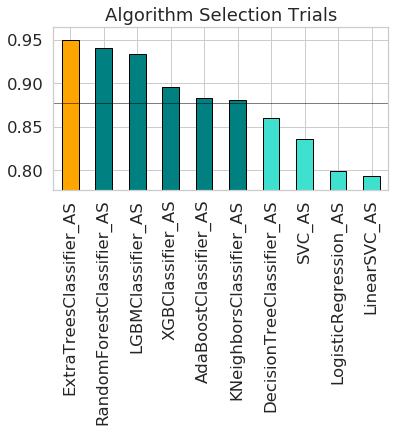

In [11]:
oracle_automl.visualize_algorithm_selection_trials()

In [14]:
###### load kaggle test dataset ######
kaggle_test_name = './d_pis/kaggle-test_{}.csv'.format(name)

kaggle_test_df = pd.read_csv(kaggle_test_name)
kaggle_test_id = np.arange(1, kaggle_test_df.shape[0]  + 1)

print(kaggle_test_df.head())
kaggle_test_df.shape

   A_follower_count  A_following_count  A_listed_count  A_mentions_received  \
0            614689                400            5729           199.618296   
1            739581              10723            1279           102.026750   
2              3638               3341              85             2.793577   
3               613               1259              31             1.326041   
4           1352348                331           15647         19129.848662   

   A_retweets_received  A_mentions_sent  A_retweets_sent    A_posts  \
0            67.812469         9.366192         0.359534   4.094488   
1            96.771319         1.537322         1.054358   3.467754   
2             1.402703         2.594089         0.598150   3.802143   
3             0.356943         6.249678         2.323064   7.488116   
4         14552.733991         2.065418         0.580955  16.281502   

   A_network_feature_1  A_network_feature_2  ...  B_following_count  \
0                  669     

(5952, 22)

In [15]:
###### predict kaggle test dataset ######

kaggle_y_pred = best_model.predict(kaggle_test_df)

assert kaggle_y_pred.shape == kaggle_test_id.shape

print(kaggle_y_pred.shape)
print(kaggle_y_pred[:100])

(5952,)
[0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0
 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1
 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0]


In [16]:
###### save kaggle prediction ######

kaggle_pred_name = './d_pis/kaggle-test_{}_predictions.csv'.format(name)

kaggle_pred_df = pd.DataFrame({id_col: kaggle_test_id, target_col: kaggle_y_pred})
print(kaggle_pred_df.head())

kaggle_pred_df.to_csv(kaggle_pred_name, index=False)

   Id  Choice
0   1       0
1   2       0
2   3       0
3   4       0
4   5       0
